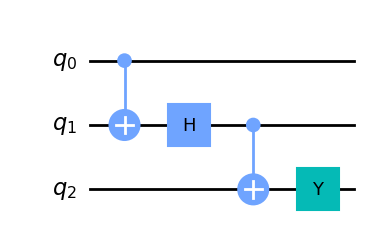

In [197]:
from virtual_swap.vswap_pass import VSwapPass

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.h(1)
qc.cx(1, 2)
qc.y(2)
original_op = Operator(qc)
qc.draw("mpl")

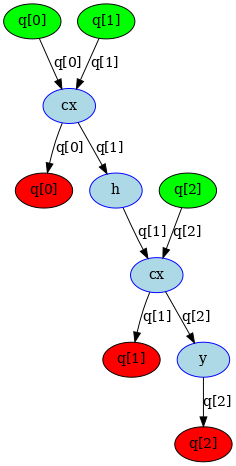

In [198]:
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(qc)
dag.draw()

In [199]:
# manually select the first cx node
from qiskit.circuit.library.standard_gates import CXGate

h_node = dag.op_nodes(CXGate)[0]

In [259]:
import numpy as np

# cx -> iswap
cx_replace = QuantumCircuit(2, 0)
cx_replace.h(1)
cx_replace.rz(-np.pi / 2, 0)
cx_replace.rz(-np.pi / 2, 1)
cx_replace.iswap(0, 1)
cx_replace.h(0)
cx_replace.draw("mpl")

# iswap -> cx
iswap_replace = QuantumCircuit(2, 0)
iswap_replace.rz(np.pi / 2, 0)
iswap_replace.rz(np.pi / 2, 1)
iswap_replace.h(1)
iswap_replace.iswap(0, 1)
iswap_replace.h(1)

In [260]:
iswap_replace.draw()

┌─────────┐     ┌────────┐     
q_0: ┤ Rz(π/2) ├─────┤0       ├─────
     ├─────────┤┌───┐│  Iswap │┌───┐
q_1: ┤ Rz(π/2) ├┤ H ├┤1       ├┤ H ├
     └─────────┘└───┘└────────┘└───┘

In [264]:
# sanity check
cx_id_check = QuantumCircuit(2, 0)
cx_id_check.append(cx_replace, [0, 1])
cx_id_check.swap(0, 1)
cx_id_check.cx(0, 1)
print(Operator(cx_id_check).equiv(np.eye(4)))

iswap_id_check = QuantumCircuit(2, 0)
iswap_id_check.append(iswap_replace, [0, 1])
iswap_id_check.swap(0, 1)
iswap_id_check.iswap(0, 1)
print(Operator(iswap_id_check).equiv(np.eye(4)))

True
False


In [190]:
from qiskit.dagcircuit import DAGOpNode, DAGInNode, DAGOutNode
from qiskit.circuit.library import iSwapGate, SwapGate


def cns_transform(dag, h_node):
    swap_wires = {
        qarg1: qarg2 for qarg1, qarg2 in zip(h_node.qargs, h_node.qargs[::-1])
    }

    # NOTE, include the node itself, because we want to reference set of all outgoing edges
    node_list = list(dag.descendants(h_node))
    node_list.insert(0, h_node)

    for source in node_list:
        # first, update edge arguments
        for target in dag.successors(source):
            edge = dag._multi_graph.get_edge_data(source._node_id, target._node_id)
            dag._multi_graph.update_edge(
                source._node_id, target._node_id, swap_wires.get(edge, edge)
            )

        # second, update the node's qargs
        if source == h_node:
            # here replace the operation...
            dag.substitute_node(source, replace_op.to_instruction(), inplace=True)
            pass

        elif isinstance(source, DAGOpNode):
            source.qargs = [swap_wires.get(qarg, qarg) for qarg in source.qargs]
        elif isinstance(source, DAGOutNode):
            source.wire = swap_wires.get(source.wire, source.wire)

    # add a swap a swap at end of circuit
    dag.apply_operation_back(SwapGate(), h_node.qargs)

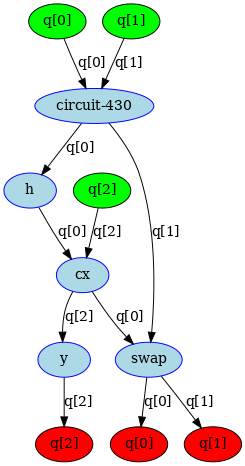

In [191]:
cns_transform(dag, h_node)
dag.draw()

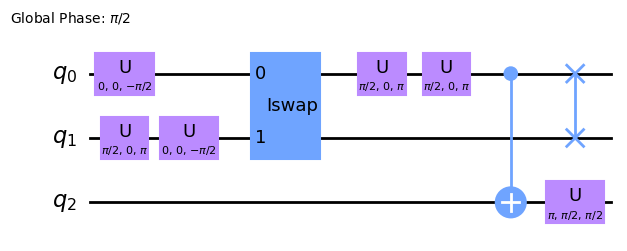

In [194]:
from qiskit.converters import dag_to_circuit

qc = dag_to_circuit(dag)

# transpile into iswap, cx, u basis
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

pm = PassManager([Unroller(["swap", "iswap", "cx", "u"])])
qc = pm.run(qc)

qc.draw("mpl")

In [195]:
# verify circuits are equivalent
from qiskit.quantum_info import Operator

original_op.equiv(Operator(qc))

True